# Convolutional Neural Network - Fashion MNIST Dataset


> Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.

## **1. Import Libaries**

In [63]:
from torch.utils.data import Dataset, DataLoader

import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
import numpy as np

## **2. Load Data**

In [64]:
IMAGE_SIZE = 16

# Generate an object to store multiple transformations
composed = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])

<hr>

In [65]:
# Create the two dataset objects and applying our transformations from above
dataset_train = datasets.FashionMNIST(root= '.fashion/data', train=True, transform=composed, download=True)
dataset_val = datasets.FashionMNIST(root= '.fashion/data', train=False, transform=composed, download=True)

In [66]:
train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=100 )
test_loader = torch.utils.data.DataLoader(dataset=dataset_val, batch_size=100 )

## **3. Visualize our data**

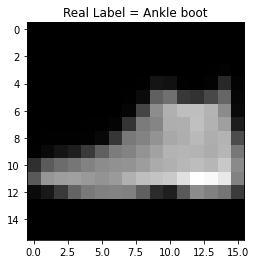

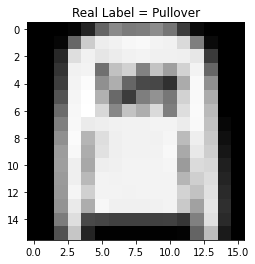

In [67]:
labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
def show_data(data_sample, size):
    plt.imshow(data_sample[0].numpy().reshape(size, size), cmap='gray')
    plt.title(f"Real Label = {labels[data_sample[1]]}")

for n, data_sample in enumerate(dataset_val):

    show_data(data_sample, IMAGE_SIZE)
    plt.show()
    if n==1:
        break

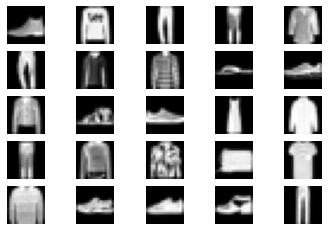

In [68]:
def plot_images(images):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure()
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(images[i].view(IMAGE_SIZE, IMAGE_SIZE).cpu().numpy(), cmap='gray')
        ax.axis('off')

n_images = 25
images = [image for image, label in [dataset_val[i] for i in range(n_images)]]
plot_images(images)

## **4. Define the Convolutional Neural Network**


In [69]:
# Every PyTorch model must inherit from torch.nn.Module
# nn.Module has very useful functions for models
class CNN(nn.Module):
    
    # Constructor: (out_1: Output channels of first CNN Layer), (out_2: Output channels of second CNN Layer), (number_of_classes: Number of classes to detect)
    def __init__(self, out_1=16, out_2=32, number_of_classes=10):
        super().__init__()

        # Create first Convolution Layer with input of 1 channel (grayscale) and output of out_1 channels
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)

        # Initialize the weights of the first Convolution Layer with He initialization for Leaky ReLU activation
        nn.init.kaiming_uniform_(self.cnn1.weight, nonlinearity='relu')

        # Create Batch Normalization for first Convolution Layer
        self.conv1_bn = nn.BatchNorm2d(out_1)

        # Create Leaky ReLU activation
        self.leaky_relu = nn.LeakyReLU()

        # Create Max Pooling for first Convolution Layer
        self.maxpool1=nn.MaxPool2d(kernel_size=2)

        # ----------------------------------------------------------------------

        # Create second Convolution Layer with input of out_1 channels (from first layer) and output of out_2 channels
        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, padding=2)

        # Initialize the weights of the second Convolution Layer with He initialization for Leaky ReLU activation
        nn.init.kaiming_uniform_(self.cnn2.weight, nonlinearity='leaky_relu')

        # Create Batch Normalization for second Convolution Layer
        self.conv2_bn = nn.BatchNorm2d(out_2)

        # Create Max Pooling for second Convolution Layer
        self.maxpool2=nn.MaxPool2d(kernel_size=2)

        # ----------------------------------------------------------------------
        
        # Create a fully connected layer for the CNN. The input shape is the flattened convolution output. If output is (3, 28, 28), input is 28 * 28 * 3.
        self.fc1 = nn.Linear(out_2 * 4 * 4, number_of_classes)
    
    # Prediction (x is input)
    # The forward function is automatically called when we create an instance of the class and call it.
    def forward(self, x):
        x = self.cnn1(x)
        x = self.conv1_bn(x)
        x = self.leaky_relu(x)
        x = self.maxpool1(x)
        
        x = self.cnn2(x)
        x = self.conv2_bn(x)
        x = self.leaky_relu(x)
        x = self.maxpool2(x)
        
        # Flattening cnn2's output and passing it into a fully connected layer
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

Create a CNN object and show the structure.


In [70]:
import torchsummary as summary
model = CNN()

summary.summary(model, (1, 16, 16))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 16, 16]             416
       BatchNorm2d-2           [-1, 16, 16, 16]              32
         LeakyReLU-3           [-1, 16, 16, 16]               0
         MaxPool2d-4             [-1, 16, 8, 8]               0
            Conv2d-5             [-1, 32, 8, 8]          12,832
       BatchNorm2d-6             [-1, 32, 8, 8]              64
         LeakyReLU-7             [-1, 32, 8, 8]               0
         MaxPool2d-8             [-1, 32, 4, 4]               0
            Linear-9                   [-1, 10]           5,130
Total params: 18,474
Trainable params: 18,474
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.15
Params size (MB): 0.07
Estimated Total Size (MB): 0.22
---------------------------------------------

In [71]:
# Create an Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.002)

# Use Cross Entropy Loss since this is a classification problem
criterion = nn.CrossEntropyLoss()

## **5. Train the network**

In [72]:
# To show a progress bar while training
from tqdm import tqdm

training_acc_list=[]
val_acc_list=[]
N_test=len(dataset_val)
N_train=len(dataset_train)
n_epochs=10

for epoch in range(n_epochs):
    #Count how many predictions were correct
    correct = 0

    print()
    print(f"Epoch no. {epoch}")

    # Put model into training mode (uses Dropout if there are Dropout layers)
    model.train()

    # Loop over each sample in the dataloaders.
    for x, y in tqdm(train_loader):
        # Zero the optimizer gradients (PyTorch requires this.)
        optimizer.zero_grad()

        # Make a prediction
        y_hat = model(x)

        # Calculate the loss with the criterion
        loss = criterion(y_hat, y)

        # Initiate backpropagation/calculate derivatives of parameters with respect to the loss.
        loss.backward()

        # Update parameters
        optimizer.step()
        
        # Update correct counter
        # Grab the index of the AI's highest probability guess (Each output of model(x) is a tensor of probabilities) 
        correct += (torch.argmax(y_hat, 1) == y).sum().item()
        
    # Calculate accuracy
    accuracy = correct / N_train
    print("Training accuracy: " + str(accuracy))
    training_acc_list.append(accuracy)

    correct=0
    
    # Put model into validation mode (turns off Dropout if there are Dropout layers)
    model.eval()
    for x_test, y_test in test_loader:
        # Make a prediction
        z = model(x_test)

        # Grab the index of the AI's highest probability guess (Each output of model(x) is a tensor of probabilities) 
        y_hat = torch.argmax(z, 1)

        # Update correct counter if the prediction was correct
        correct += (y_hat == y_test).sum().item()
    accuracy = correct / N_test
    print("Validation accuracy: " + str(accuracy))
    val_acc_list.append(accuracy)


Epoch no. 0


100%|██████████| 600/600 [00:26<00:00, 22.85it/s]


Training accuracy: 0.8375
Validation accuracy: 0.849

Epoch no. 1


100%|██████████| 600/600 [00:27<00:00, 21.94it/s]


Training accuracy: 0.8799666666666667
Validation accuracy: 0.8688

Epoch no. 2


100%|██████████| 600/600 [00:27<00:00, 21.90it/s]


Training accuracy: 0.8925833333333333
Validation accuracy: 0.8762

Epoch no. 3


100%|██████████| 600/600 [00:28<00:00, 21.37it/s]


Training accuracy: 0.9002
Validation accuracy: 0.8829

Epoch no. 4


100%|██████████| 600/600 [00:26<00:00, 22.67it/s]


Training accuracy: 0.90625
Validation accuracy: 0.8852

Epoch no. 5


100%|██████████| 600/600 [00:27<00:00, 22.08it/s]


Training accuracy: 0.9114166666666667
Validation accuracy: 0.8857

Epoch no. 6


100%|██████████| 600/600 [00:27<00:00, 22.13it/s]


Training accuracy: 0.9152166666666667
Validation accuracy: 0.8856

Epoch no. 7


100%|██████████| 600/600 [00:28<00:00, 21.29it/s]


Training accuracy: 0.91985
Validation accuracy: 0.8875

Epoch no. 8


100%|██████████| 600/600 [00:26<00:00, 22.31it/s]


Training accuracy: 0.9231333333333334
Validation accuracy: 0.8871

Epoch no. 9


100%|██████████| 600/600 [00:29<00:00, 20.66it/s]


Training accuracy: 0.9245333333333333
Validation accuracy: 0.8853


## **6. Plot accuracies**

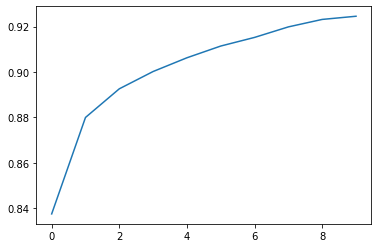

In [73]:
plt.plot(training_acc_list)

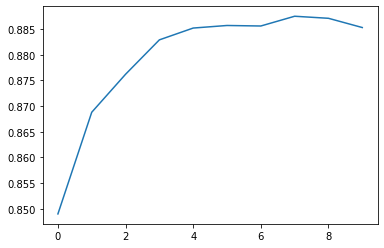

In [74]:
plt.plot(val_acc_list)

In [78]:
# We can save our model's weights by running the following:
torch.save(model.state_dict(), "MNIST.pth")

In [76]:
# We can load the model's weights by running the following:
model.load_state_dict(torch.load("MNIST.pth"))

<All keys matched successfully>

## **7. Test Test Data with our Trained Network**


Model Prediction: Dress


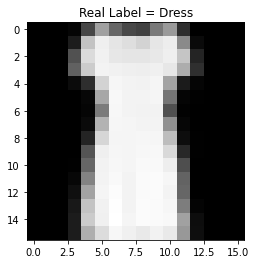

In [86]:
import random
model.eval()
randomIndex = random.randint(0, len(dataset_val) - 1)
test = dataset_val[randomIndex]
show_data(test, IMAGE_SIZE)

# Turn image of (C, H, W) into (B, C, H, W) to pass into the model
# Take the index of the highest probability from the output tensor and grab the corresponding classification
print("Model Prediction: " + labels[torch.argmax(model(test[0].view(-1, 1, 16, 16)), 1)])